# Auto-encoders

## Definition and purpose

> An autoencoder is an artificial neural network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction.
> [...]
> An autoencoder learns to compress data from the input layer into a short code, and then uncompress that code into something that closely matches the original data. This forces the autoencoder to engage in dimensionality reduction

> [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

## Sources

[1] - [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf). And why they’re so useful in creating your own generative text, art and even music  
[2] - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [1]:
import tensorflow as tf
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

C:\Users\cedro\Anaconda2\envs\tf-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading data

We will train our encoders to reconstruct MNIST digits.

In [2]:
# load MNIST images 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print (f"Loaded {x_train.shape[0]} train samples and {x_test.shape[0]} test samples.")
print (f"Each sample is a grayscale image of dimensions {x_train[0].shape} that will be flatten to a vector of {np.prod(x_train[0].shape)} elements")

# normalize and flatten
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape+(1,))
x_test = x_test.reshape(x_test.shape + (1,))

x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


data_dim = x_train_flat.shape[1]

print (f"original shape = {x_train.shape}")
print (f"flatten shape = {x_train_flat.shape}")


Loaded 60000 train samples and 10000 test samples.
Each sample is a grayscale image of dimensions (28, 28) that will be flatten to a vector of 784 elements
original shape = (60000, 28, 28, 1)
flatten shape = (60000, 784)


## Simple AE

We will first build the simplest possible AE, with a single fully-connected neural layer as encoder and as decoder.

In [5]:
def create_simple_ae(data_dim, latent_dim):

    # image input layer
    input_img = Input(shape=(data_dim,))
    # encoded representation : compressed data
    encoded = Dense(latent_dim, activation='relu')(input_img)
    # decoded representation : reconstruction of the input
    decoded = Dense(data_dim, activation='sigmoid')(encoded)

    # model definition
    autoencoder = Model(input_img, decoded)

    # create seperate models for encoder and decoder for final evaluation
    encoder = Model(input_img, encoded)

    encoded_input = Input(shape=(latent_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    return autoencoder, encoder, decoder

In [6]:
autoencoder, encoder, decoder = create_simple_ae(data_dim, 32)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train_flat, x_train_flat, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_flat, x_test_flat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 35s 580us/step - loss: 0.3554 - val_loss: 0.2710
Epoch 2/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2643 - val_loss: 0.2541
Epoch 3/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2437 - val_loss: 0.2308
Epoch 4/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2221 - val_loss: 0.2115
Epoch 5/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2057 - val_loss: 0.1978
Epoch 6/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1940 - val_loss: 0.1877
Epoch 7/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.1852 - val_loss: 0.1801
Epoch 8/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.1784 - val_loss: 0.1740
Epoch 9/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.1727 - val_loss: 0.1689
Epo

In [3]:
def show_comparison(input, output, n):

    plt.figure(figsize=(2*n,4))
    for i in range(n):
        # original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(input[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    

        # reconstructed
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(output[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
    plt.show()
    
def show_generation(output, n):

    plt.figure(figsize=(2*n,2))
    for i in range(n):
        # reconstructed
        ax = plt.subplot(1, n, i+1)
        plt.imshow(output[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
    plt.show()
    
def show_latent(latent, labels, n):
    
    print (f"Mean  :{np.mean(latent, axis=0)}")
    print (f"StdDev:{np.std(latent, axis=0)}")
    print (f"Min   :{np.min(latent, axis=0)}")
    print (f"Max   :{np.max(latent, axis=0)}")

    latent_reduced = TSNE(n_components=2).fit_transform(latent[:n])

    plt.figure()
    plt.scatter(latent_reduced[:, 0], latent_reduced[:, 1], c=labels[:n])
    plt.colorbar()
    plt.set_cmap('jet')
    plt.show()

Encode and decode some test samples

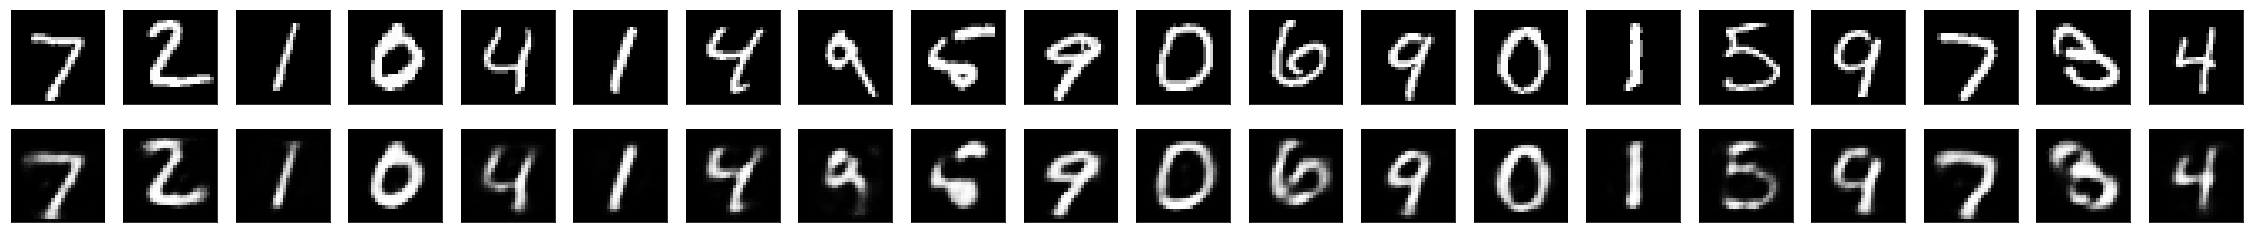

Mean  :[ 7.5265884  7.964769   8.013605   8.338931  11.6912565  4.9388566
 11.997984   5.002981   7.284579   7.2010303  7.220264   4.8753705
 10.043766  11.015681   3.861109   8.462334  12.544915  10.345428
  5.1454773  9.104999   3.9568493  7.690087   5.0491033  8.007682
  9.8521805  4.9429126  4.526186  10.145746   7.7169585  4.6840878
  7.342321   5.8341746]
StdDev:[3.7841454 4.1039557 3.7008944 4.661233  5.208899  3.2337286 5.9637923
 2.640531  3.5894918 3.8306532 3.8846858 2.7499495 4.5441585 4.8263807
 1.8810183 3.7700686 4.87789   4.494134  2.87573   4.153566  2.080383
 4.08473   2.7803328 3.907965  4.3094864 2.8837218 2.9008498 4.855868
 4.043542  2.419562  3.9641843 2.8055577]
Min   :[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Max   :[20.03572  23.810743 20.761057 27.097406 33.604935 15.040333 32.371925
 17.035183 22.579525 26.01614  19.306843 17.800978 26.864841 31.427235
 11.979084 22.367716 31.40628  28.366499 17.112043

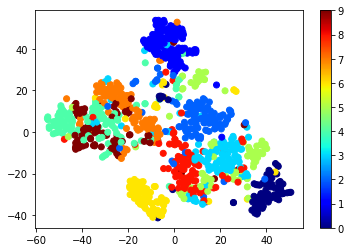

In [14]:
encoded_imgs = encoder.predict(x_test_flat)
decoded_imgs = decoder.predict(encoded_imgs)

show_comparison(x_test_flat, decoded_imgs, 20)
show_latent(encoded_imgs, y_test, 1000)

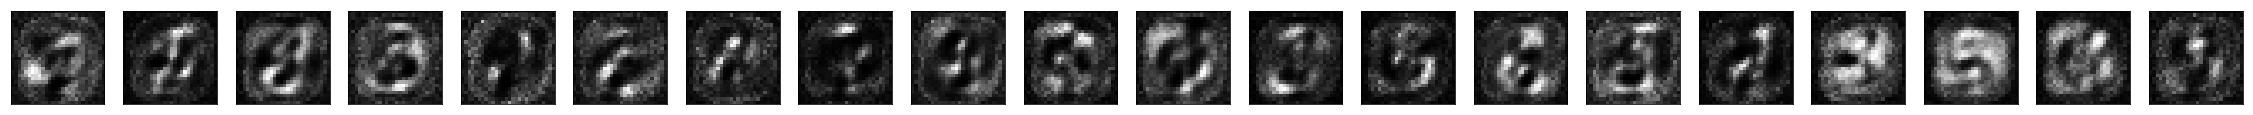

In [81]:
# try to generate from random compressed data
encoded_imgs = np.random.random((20,32))*4
decoded_imgs = decoder.predict(encoded_imgs)

show_generation(decoded_imgs, 20)

## Sparse AE

Note: According to [2], this should give better results...

In [6]:
def create_sparse_ae(data_dim, latent_dim):

    # image input layer
    input_img = Input(shape=(data_dim,))
    # encoded representation : compressed data
    # L1 activity regularizer as sparsity constraint
    encoded = Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
    # decoded representation : reconstruction of the input
    decoded = Dense(data_dim, activation='sigmoid')(encoded)

    # model definition
    autoencoder = Model(input_img, decoded)

    # create seperate models for encoder and decoder for final evaluation
    encoder = Model(input_img, encoded)

    encoded_input = Input(shape=(latent_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    return autoencoder, encoder, decoder

In [7]:
sparse_ae, sparse_encoder, sparse_decoder = create_sparse_ae(data_dim, 32)

sparse_ae.compile(optimizer='adadelta', loss='binary_crossentropy')
sparse_ae.fit(x_train_flat, x_train_flat, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test_flat, x_test_flat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.6726 - val_loss: 0.6484
Epoch 2/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.4531 - val_loss: 0.4

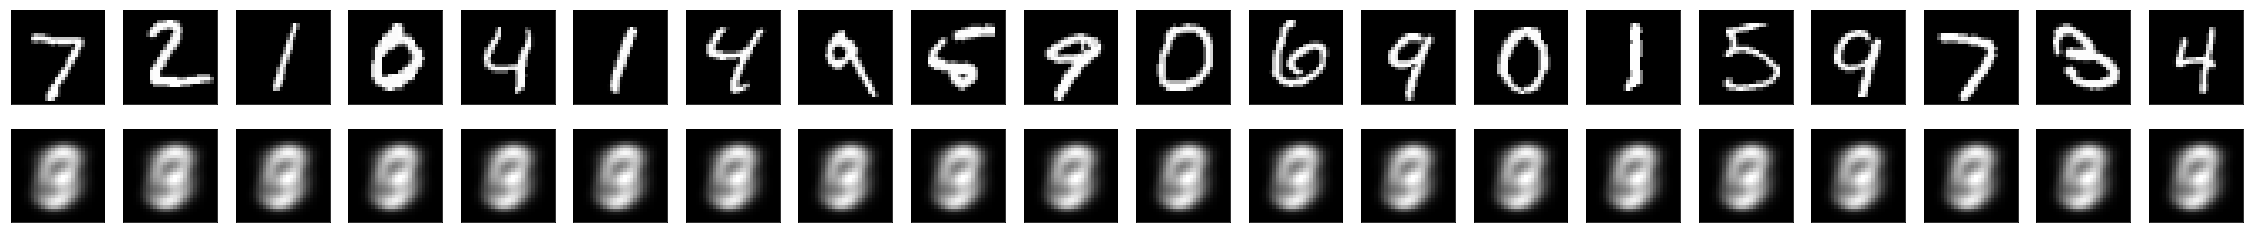

Mean  :[0.0000000e+00 0.0000000e+00 1.7098662e-06 0.0000000e+00 0.0000000e+00
 2.5431623e-06 0.0000000e+00 6.3901603e-06 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.5492796e-06
 0.0000000e+00 0.0000000e+00 6.3993484e-06 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5945876e-05 0.0000000e+00 0.0000000e+00 1.9256104e-05
 0.0000000e+00 0.0000000e+00 1.1350348e-05 0.0000000e+00 1.6648692e-05
 0.0000000e+00 0.0000000e+00]
StdDev:[0.         0.         0.00017097 0.         0.         0.00025429
 0.         0.00051208 0.         0.         0.         0.
 0.         0.         0.00055488 0.         0.         0.00063989
 0.         0.         0.         0.00159445 0.         0.
 0.00192544 0.         0.         0.00113492 0.         0.00166474
 0.         0.        ]
Min   :[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Max   :[0.         0.         0.01709866 0.         0.         0.02543162
 0.    

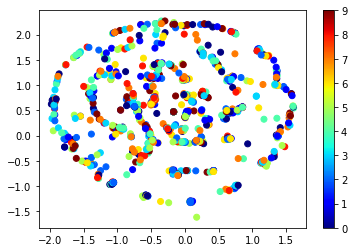

In [8]:
encoded_imgs = sparse_encoder.predict(x_test_flat)
decoded_imgs = sparse_decoder.predict(encoded_imgs)

show_comparison(x_test_flat, decoded_imgs, 20)
show_latent(encoded_imgs, y_test, 1000)

## Deep AE

We can add several layers in the encoder and decoders.

In [4]:
def create_deep_ae(data_dim, encoder_dims, decoder_dims):

    # encoder model definition
    encoder_inputs = Input(shape=(data_dim,))
    x = encoder_inputs
    for dim in encoder_dims:
        x = Dense(dim, activation='relu')(x)
    encoder = Model(encoder_inputs, x, name='encoder')
    encoder.summary()
        
    # decoder model definition
    decoder_inputs = Input(shape=(encoder_dims[-1],))
    x = decoder_inputs
    for dim in decoder_dims[:-1]:
        x = Dense(dim, activation='relu')(x)
    x = Dense(decoder_dims[-1], activation='sigmoid')(x)
    decoder = Model(decoder_inputs, x, name='decoder')
    decoder.summary()
    
    # AE model definition
    autoencoder = Model(encoder_inputs, decoder(encoder(encoder_inputs)), name='autoencoder')
    autoencoder.summary()

    return autoencoder, encoder, decoder

In [5]:
deep_ae, deep_encoder, deep_decoder = create_deep_ae(data_dim, [128,64,32], [64,128,784])

deep_ae.compile(optimizer='adadelta', loss='binary_crossentropy')
deep_ae.fit(x_train_flat, x_train_flat, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test_flat, x_test_flat))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dens

KeyboardInterrupt: 

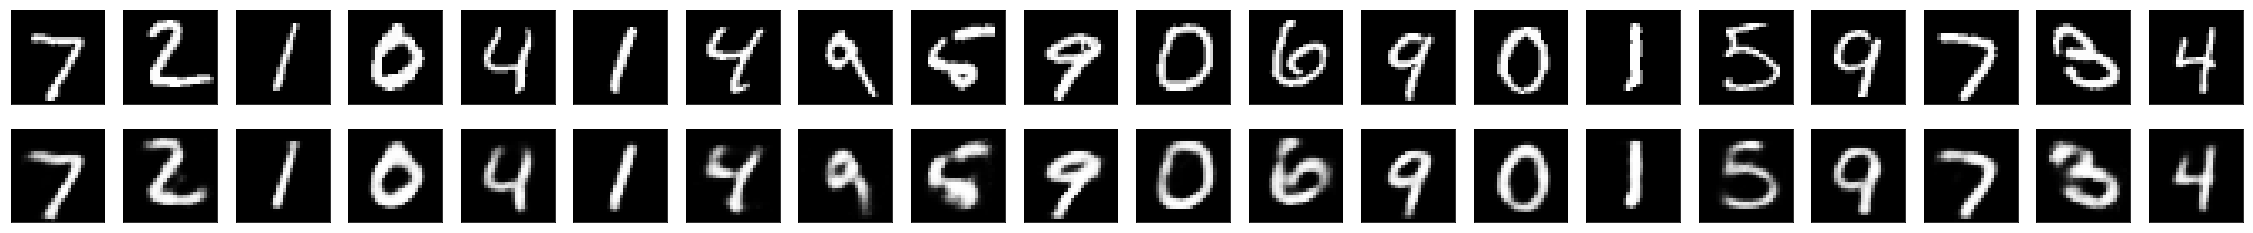

Mean  :[8.7404136e-05 6.5341315e+00 4.9557967e+00 7.7331586e+00 2.7135720e+00
 6.8663297e+00 1.5888237e+00 4.4060025e+00 4.4971815e-04 6.6832623e+00
 7.5786538e+00 3.6455758e+00 6.1868701e+00 5.5405807e+00 9.2643394e+00
 4.2020316e+00 3.5489473e+00 4.2846030e-05 6.9387884e+00 7.8651476e+00
 6.4518342e+00 6.9072146e+00 6.1259031e+00 6.3021283e+00 8.8034134e+00
 0.0000000e+00 6.9990096e+00 8.7409964e+00 3.2542218e-03 0.0000000e+00
 5.4274411e+00 7.1015162e+00]
StdDev:[4.9337633e-03 3.8743248e+00 2.7319434e+00 4.0522118e+00 1.6243780e+00
 4.1011591e+00 1.3362460e+00 2.2389874e+00 1.4685621e-02 3.5340977e+00
 4.1290221e+00 2.1580091e+00 3.2550132e+00 3.2967377e+00 4.1564302e+00
 2.5510972e+00 2.0121531e+00 2.6604286e-03 3.1514084e+00 4.0245013e+00
 3.0551624e+00 3.0310919e+00 3.5115259e+00 3.4781768e+00 4.8980818e+00
 0.0000000e+00 3.3350086e+00 4.2362285e+00 4.0445939e-02 0.0000000e+00
 2.8937197e+00 3.6747799e+00]
Min   :[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

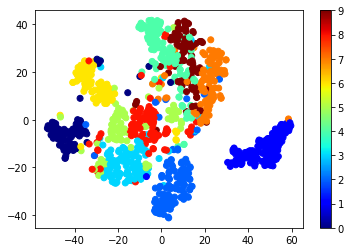

In [12]:
encoded_imgs = deep_encoder.predict(x_test_flat)
decoded_imgs = deep_decoder.predict(encoded_imgs)

show_comparison(x_test_flat, decoded_imgs, 20)
show_latent(encoded_imgs, y_test, 1000)

## Convolutional AE
Since the inputs are images, let use CNN as encoders and decoders.

In [6]:
def create_conv_ae(input_shape):

    input_img = Input(shape=input_shape)  # adapt this if using `channels_first` image data format

    # encoder model definition
    encoder_inputs = input_img
    x = encoder_inputs
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    encoder = Model(encoder_inputs, x, name='encoder')
    encoder.summary()

    # decoder model definition
    decoder_inputs = Input(shape=encoder.layers[-1].output_shape[1:])
    x = decoder_inputs
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    
    decoder = Model(decoder_inputs, x, name='decoder')
    decoder.summary()

    # AE model definition
    autoencoder = Model(input_img, decoder(encoder(input_img)), name='autoencoder')
    autoencoder.summary()

    return autoencoder, encoder, decoder


Start a TensorBoard instance in a console 
    
    tensorboard --logdir=%tmp%\autoencoders

In [7]:
conv_ae, conv_encoder, conv_decoder = create_conv_ae((28,28,1))

conv_ae.compile(optimizer='adadelta', loss='binary_crossentropy')
conv_ae.fit(x_train, x_train, 
            epochs=50, batch_size=128, shuffle=True, 
            validation_data=(x_test, x_test),
            callbacks=[TensorBoard(log_dir='C:\\Users\\cedro\\AppData\\Local\\Temp\\autoencoders')])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
Total para

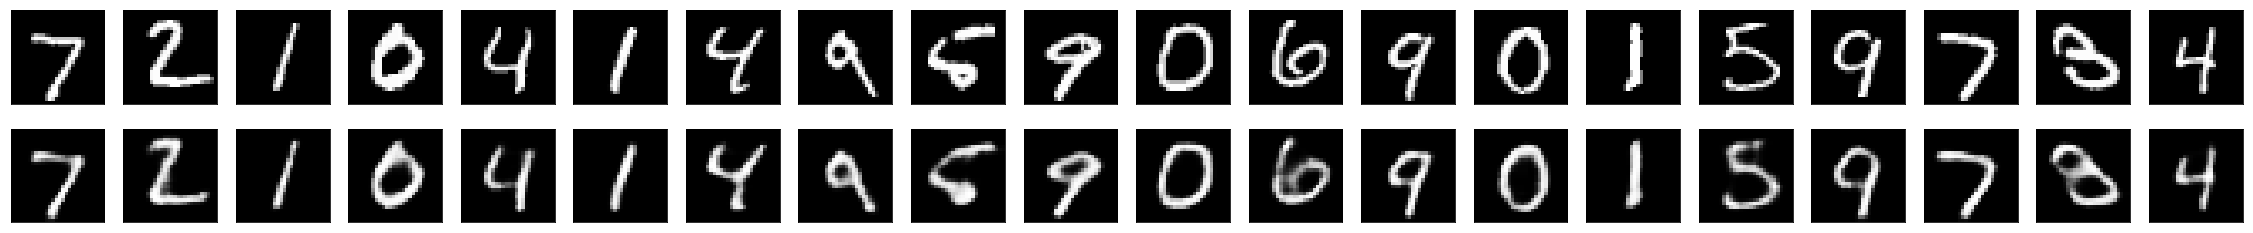

In [8]:
encoded_imgs = conv_encoder.predict(x_test)
decoded_imgs = conv_decoder.predict(encoded_imgs)

show_comparison(x_test, decoded_imgs, 20)